<h1 style="font-size:3.2rem;color:#1351b4; text-align:center;">Pipeline de Classificação de Propostas</h1>

A plataforma do [Brasil Participativo](https://brasilparticipativo.presidencia.gov.br/processes/programas/f/2/) é uma nova aplicação digital do governo federal, software livre Decidim e um espaço para que a população possa contribuir na elaboração e votação de propostas para melhorar o serviço e definição de políticas públicas.

Por ser uma plataforma recente, ela não possui indexação automática das propostas. Isto é, não possui uma forma de categorização automatizada das propostas e o volume de propostas cadastradas até então já despende um esforço humano manual considerável. Então, o foco deste projeto é fazer uma análise das propostas por meio de processamento de linguagem natural (PLN) e automatizar esse processo de categorização. 

A partir disso, um modelo MVP (produto com mínima viabilidade) definido junto com o cliente seria um sistema classificador/categorizador das propostas publicadas na plataforma, sendo as categorias baseadas nos Ministérios do Brasil (cerca de 40 categorias). Uma outra forma de categorização, baseada no tópico principal da proposta, também pertence à arquitetura do sistema. Além disso, cogitou-se também a adição de um classificador de discurso de ódio ao pipeline do sistema, porém não foi realizado dado o caráter sensível da análise de discurso de ódio.

Mais detalhes sobre o MVP do sistema abaixo.

<div style="border: thin dotted yellow; border-radius: 8px; padding-top: 15px; padding-bottom: 15px;">
Este Notebook consiste na apresentação do pipeline de desenvolvimento do projeto NLP do Brasil Participativo.

<img style="float:left; margin: 5px 20px 5px 20px;" alt="Work in Progress" src="https://cdn-icons-png.flaticon.com/512/5578/5578703.png" width=80 height=75>

Trata-se de um projeto MVP, ou seja, uma versão mínima viável aplicável à plataforma do cliente. Conforme a finalização dos procedimentos no repositório do GitHub, as novas informações estão sendo incrementadas ao documento.
</div>

<a id='1'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Sumário</h2>

- [Extração dos dados](#data-extraction)
  - [Importação das bibliotecas](#data-extraction-1)
  - [Baixando dataset original](#data-extraction-2)
  - [Extração do arquivo CSV](#data-extraction-3)
  - [Leitura das propostas](#data-extraction-4)
  - [Limpeza e seleção das colunas](#data-extraction-5)
- [Propostas Simuladas](#new-proposals)
- [Pré-processamento textual](#pre-processing)
  - [Definições iniciais](#pre-processing-1)
  - [Pré-processameno](#pre-processing-2)
    - [Indexação das categorias](#pre-processing-2-1)
    - [Técnicas de NLP](#pre-processing-2-2)
  - [Vetorização textual](#pre-processing-3)
- [Agrupamento em tópicos](#text-clustering)
- [Dataset de propostas do Brasil Participativo](#dataset)
- [Classificação de propostas](#training-model)
  - [Importação das bibliotecas](#training-model-1)
  - [Configurações do modelo](#training-model-2)
- [Utilização](#how-to-use)
  - [Serialização](#how-to-use-1)
  - [Carregamento](how-to-use-2)
- [Histórico de versões do Pipeline](#history)

<a id='data-extraction'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Extração dos Dados</h2>

A primeira etapa para o desenvolvimento do projeto é a extração dos dados. Nesta etapa, os dados das propostas são baixados da plataforma e o foco é garantir que os dados vazios ou repetidos não sejam repassados para próxima etapa.

A elaboração e submissão de novas propostas no Brasil Participativo ocorre periodicamente em eventos. Foram abertas e encerradas inicialmente junto com o Plano Plurianual ([PPA](https://www.gov.br/economia/pt-br/assuntos/planejamento-e-orcamento/plano-plurianual-ppa)) de 2023 para o planejamento orçamentário do governo e e foi aberto novamente durante a Conferência da Juventude, na UnB . Atualmente a quantidade bruta de propostas disponibilizadas para uma base de dados é de aproximadamente **11000 propostas**. Apesar da quantia ser considerável, ainda é pequena para o treinamento de um algoritmo classificador de propostas, dada a quantidade de categorias existentes e tendo em vista a desproporção de propostas por categoria.

Os dados estão disponibilizados no rodapé do site, conforme a imagem abaixo, no link "Baixar arquivos de Dados Abertos". Os arquivos com os dados das propostas (em formato `csv`) estão compactados e necessitam ser extraídos.

<img style="display:block; margin-left:auto; margin-right:auto;" src="assets/Screenshot from 2023-07-24 09-06-18.png" alt="Screenshot" width=864 height=486>

<a id='data-extraction-1'></a><h3 style="font-size:1.5rem;">Importação das bibliotecas</h3>

In [1]:
import pandas as pd
import re, io, os
import requests
from zipfile import ZipFile
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame

Essas serão algumas das bibliotecas utilizadas no algoritmo. Dentre delas, o uso da biblioteca Pandas responsável por manipular os dados em um DataFrame.

As outra bibliotecas são usadas como recursos que serão esclarecidos no decorrer do pipeline. 

<a id='data-extraction-2'></a><h3 style="font-size:1.5rem;">Baixando <i>dataset</i> original</h3>

In [ ]:
# Requisição ao site através do link para receber o dataset
url = "https://brasilparticipativo.presidencia.gov.br/open-data/download"
res = requests.get(url, verify=False)
if res.status_code == 200:
    print("Acesso realizado com sucesso!")
else: 
    print("Falha no acesso ao arquivo zip!")

A biblioteca Requests é utilizada para realizar uma requisição GET no link e receber o arquivo `zip`.

<a id='data-extraction-3'></a><h3 style="font-size:1.5rem;">Extração do arquivo CSV</h3>

In [ ]:
# Extrai o arquivo zip do brasil participativo
with ZipFile(io.BytesIO(res.content), 'r') as zip_ref:
    for arquivo in zip_ref.namelist():
        if arquivo.endswith('brasilparticipativo.presidencia.gov.br-open-data-proposals.csv'):
            zip_ref.extract(arquivo, 'production/data_extraction/')
            break

O `zip` contém vários arquivos, porém busca-se extrair o `csv` que contém os dados das propostas e categorias com a biblioteca ZipFile.

<a id='data-extraction-4'></a><h3 style="font-size:1.5rem;">Leitura das propostas</h3>

In [2]:
# Lê as propostas com o Pandas
propostas = pd.read_csv("production/data_extraction/brasilparticipativo.presidencia.gov.br-open-data-proposals.csv", delimiter=";")

propostas  # Impressão do DataFrame de propostas

,id,category/id,category/name/pt-BR,scope/id,scope/name/en,scope/name/pt-BR,participatory_space/id,participatory_space/url,component/id,title/pt-BR,...,attachments,followers,published_at,url,meeting_urls,related_proposals,is_amend,original_proposal/title,original_proposal/url,category/name/en
0,1,30.0,Turismo,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/processes/programas?participatory_process_slug=programas,1,Turismo: esse é o Destino,...,1,1,2023-05-10 10:03:41 -0300,http://brasilparticipativo.presidencia.gov.br/processes/programas/f/1/proposals/1,NaN,NaN,False,NaN,NaN,NaN
1,8,31.0,Desenvolvimento Agrário e Agricultura Familiar,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/processes/programas?participatory_process_slug=programas,1,Agricultura Familiar e Agroecologia,...,1,0,2023-05-10 16:22:51 -0300,http://brasilparticipativo.presidencia.gov.br/processes/programas/f/1/proposals/8,NaN,NaN,False,NaN,NaN,NaN
2,9,1.0,Agricultura e Pecuária,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/processes/programas?participatory_process_slug=programas,1,Agropecuária Sustentável,...,1,0,2023-05-10 16:35:47 -0300,http://brasilparticipativo.presidencia.gov.br/processes/programas/f/1/proposals/9,NaN,NaN,False,NaN,NaN,NaN
3,10,27.0,Saúde,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/processes/programas?participatory_process_slug=programas,1,Atenção Primária à Saúde,...,1,517,2023-05-10 16:42:43 -0300,http://brasilparticipativo.presidencia.gov.br/processes/programas/f/1/proposals/10,NaN,NaN,False,NaN,NaN,NaN
4,11,27.0,Saúde,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/processes/programas?participatory_process_slug=programas,1,Atenção Especializada à Saúde,...,1,385,2023-05-10 16:41:01 -0300,http://brasilparticipativo.presidencia.gov.br/processes/programas/f/1/proposals/11,NaN,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,14066,65.0,IV - Direito à Diversidade e à Igualdade,1.0,NaN,Brasil,1,http://brasilparticipativo.presidencia.gov.br/assemblies/confjuv4?assembly_slug=confjuv4,10,Bulling Zero nas escolas,...,0,1,2023-10-30 23:38:15 -0300,http://brasilparticipativo.presidencia.gov.br/assemblies/confjuv4/f/10/proposals/14066,NaN,NaN,False,NaN,NaN,NaN
10748,14067,69.0,VI - Direito à Cultura,1.0,NaN,Brasil,1,http://brasilparticipativo.presidencia.gov.br/assemblies/confjuv4?assembly_slug=confjuv4,10,Centros Culturais para Jovens,...,0,1,2023-10-30 23:36:53 -0300,http://brasilparticipativo.presidencia.gov.br/assemblies/confjuv4/f/10/proposals/14067,NaN,NaN,False,NaN,NaN,NaN
10749,14068,69.0,VI - Direito à Cultura,1.0,NaN,Brasil,1,http://brasilparticipativo.presidencia.gov.br/assemblies/confjuv4?assembly_slug=confjuv4,10,Passe Cultural para Estudantes,...,0,1,2023-10-30 23:41:07 -0300,http://brasilparticipativo.presidencia.gov.br/assemblies/confjuv4/f/10/proposals/14068,NaN,NaN,False,NaN,NaN,NaN
10750,14069,68.0,V - Direito à Saúde,1.0,NaN,Brasil,1,http://brasilparticipativo.presidencia.gov.br/assemblies/confjuv4?assembly_slug=confjuv4,10,Políticos e familiares serem obrigados a usarem o SUS,...,0,1,2023-10-30 23:42:59 -0300,http://brasilparticipativo.presidencia.gov.br/assemblies/confjuv4/f/10/proposals/14069,NaN,NaN,False,NaN,NaN,NaN


Perceba que existem muitos dados nulos (`NaN`) e muitas colunas desnecessárias para o treinamento do modelo. Para classificação em ministérios, são necessários somente as colunas: `category/name/pt-BR`, `title/pt-BR` e `body/pt-BR`.

<a id='data-extraction-5'></a><h3 style="font-size:1.5rem;">Limpeza e seleção das colunas</h3>

In [3]:
# Seleciona apenas as colunas importantes
propostas = pd.DataFrame(propostas, columns=['category/name/pt-BR','title/pt-BR','body/pt-BR'])
propostas.rename(columns={'category/name/pt-BR': 'Categoria', 'title/pt-BR': 'Título', 'body/pt-BR': 'Corpo'}, inplace=True)

# Retira as linhas que estao vazias
propostas = propostas.dropna()
propostas.drop(propostas[propostas['Título'] == 'Tema '].index, inplace=True)  # Removendo coluna "Tema "

# Une as colunas de Título e Corpo em uma única coluna e exclui as antigas 
propostas['Texto'] = propostas['Título'] + '. ' + propostas['Corpo']
propostas = propostas[['Categoria', 'Texto']]
propostas.head()  # Impressão das cinco primeiras linhas de propostas

,Categoria,Texto
0,Turismo,"Turismo: esse é o Destino. <p><strong>Objetivo:</strong> Posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.<br><br><strong>Órgão Responsável:</strong> Ministério do Turismo<br><br><strong>Página Oficial: </strong>https://www.gov.br/turismo/pt-br/</p>"
1,Desenvolvimento Agrário e Agricultura Familiar,"Agricultura Familiar e Agroecologia. <p><strong>Objetivo: </strong>Fortalecer a agricultura familiar em sua diversidade e a agroecologia, promovendo a inclusão socioeconômica, com fomento à produção sustentável e à geração de renda, contribuindo para a promoção da segurança alimentar e nutricional e da vida digna, com redução das desigualdades e mitigação das mudanças climáticas.<br><br><strong>Órgão Responsável: </strong>Ministério do Desenvolvimento Agrário<br><strong><br>Página Oficial:</strong> <a href=""https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1"" rel=""noopener noreferrer"" target=""_blank"">https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1</a></p>"
2,Agricultura e Pecuária,"Agropecuária Sustentável. <p>Objetivo: Contribuir para o desenvolvimento do setor agropecuário, com sustentabilidade ambiental, econômica e social, por meio do fomento e da intensificação da produção; da geração, compartilhamento e aplicação de conhecimento técnico-científico; e da regulamentação, certificação, auditoria e fiscalização agropecuária.</p><p>Órgão Responsável: Ministério da Agricultura e Pecuária</p><p>Página Oficial: http://www.gov.br/agricultura/pt-br/</p>"
3,Saúde,"Atenção Primária à Saúde. <p>Fortalecer a Atenção Primária à Saúde, ampliando a cobertura da Estratégia de Saúde da Família e da Saúde Bucal, com vistas à universalização do acesso, à abrangência do cuidado integral, à promoção da saúde, à prevenção de agravos e à redução de desigualdades de raça/etnia, de gênero, regionais e sociais</p><p><strong>Órgão Responsável</strong>: Ministério da Saúde</p><p><strong>Página Oficial</strong>: https://www.gov.br/saude/pt-br/</p><p>Foto: Divulgação/Governo Federal</p>"
4,Saúde,"Atenção Especializada à Saúde. <p>Ampliar o acesso às ações e serviços da Atenção Especializada à Saúde, conforme as necessidades de saúde da população, reduzindo as desigualdades de raça/etnia, de gênero, regionais e sociais, e promovendo a integralidade do cuidado</p><p><strong>Órgão Responsável</strong>: Ministério da Saúde</p><p><strong>Página Oficial</strong>: <a href=""https://www.gov.br/saude/pt-br/"" rel=""noopener noreferrer"" target=""_blank"">https://www.gov.br/saude/pt-br/</a></p><p>Foto: Divulgação/Ministério da Saúde</p>"


Os dados da variável `propostas` são então tratados para conter apenas as informações necessárias para classificação das propostas e, por fim, é realizado a limpeza das linhas com valores em branco.

In [4]:
print(f'Após a remoção dos valores nulos, sobraram {len(propostas)} propostas.')

Após a remoção dos valores nulos, sobraram 10723 propostas.


<a id='new-proposals'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Propostas Simuladas</h2>

Podemos vizualizar a distribuição das propostas em suas categorias no gráfico abaixo. Perceba que a quantidade de propostas por categoria é desproporcionalmente distribuído; isso é natural de ocorrer. Todavia, para treinamento de um classificador, é necessário uma boa quantidade de dados para cada uma das categorias. Logo, as categorias com menos dados não terão uma performance muito boa. 

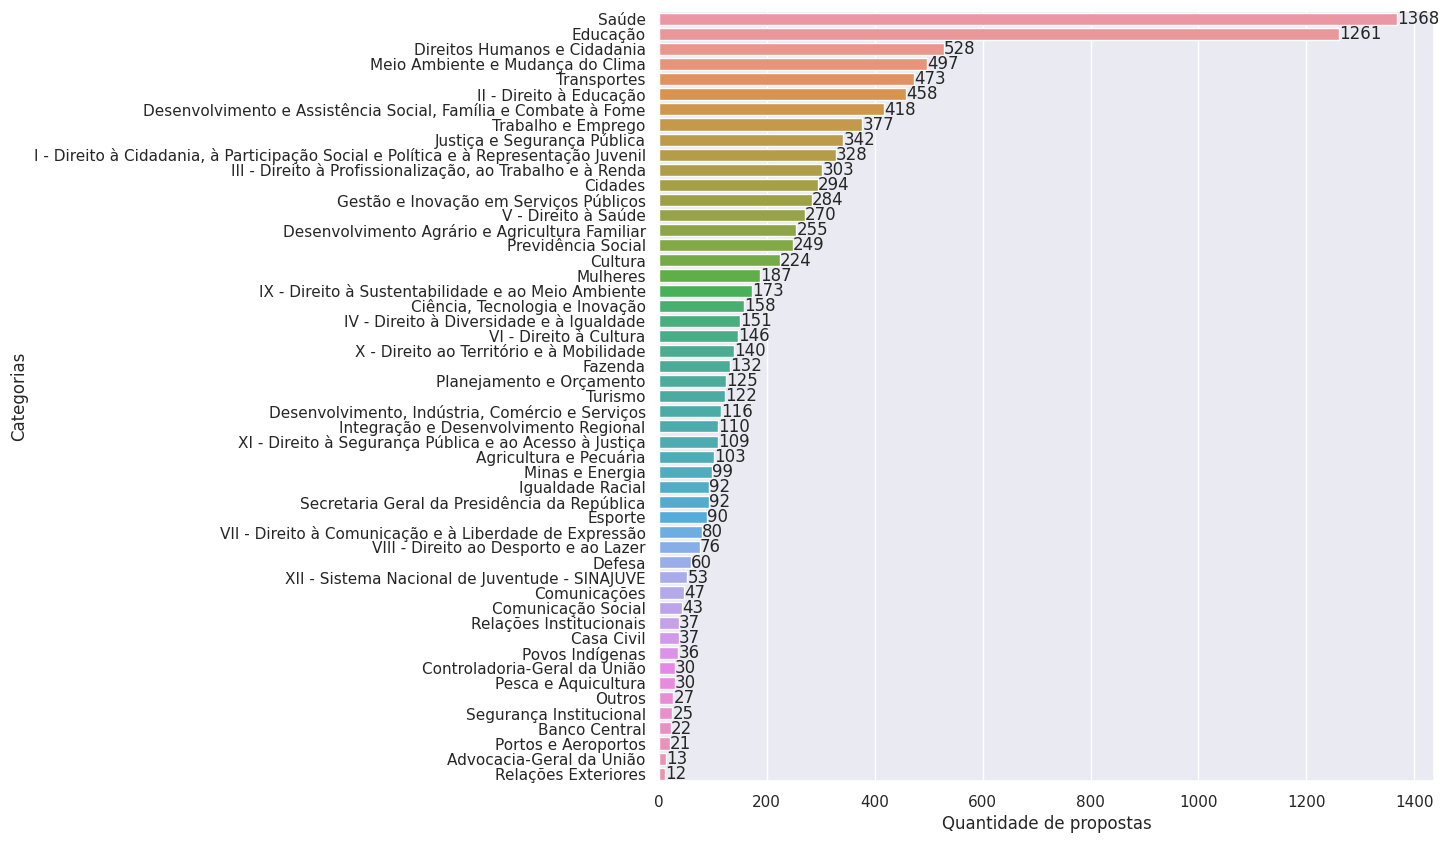

In [5]:
# Biblioteca pra visualização de gráficos
import seaborn as sns

def plot_distribution():
    sns.set(font_scale=1.0) # Definindo tamanho da fonte
    counts = propostas.groupby(["Categoria"])["Categoria"].count()  # Contando valores por categoria
    counts.sort_values(ascending=False, inplace=True) # Ordenando valores

    ax = sns.barplot(y=counts.index, x=counts)  # Criando gráfico
    ax.set(xlabel='Quantidade de propostas', ylabel='Categorias') # Labels do gráfico
    for i in ax.containers: # Valores das barras
        ax.bar_label(i,)
    ax.figure.set_size_inches(10, 10) # Definição do tamanho do gráfico

plot_distribution()

Além das propostas disponibilizadas pela plataforma do Brasil Participativo, também foram simuladas novas propostas a fim de melhorar a performance e qualidade do modelo, tais propostas foram geradas manualmente ao decorrer do projeto e podem ser acessadas `/production/data_extraction/propostas_simuladas.csv`.

In [6]:
# Lê as propostas com o Pandas

simuladas = pd.read_csv("production/data_extraction/propostas_simuladas.csv")
simuladas  # Impressão do DataFrame de propostas

,Categoria,Texto
0,Casa Civil,"É ótimo ver a conscientização sobre igualdade no trabalho crescer. Na Casa Civil, vocês podem liderar o caminho, incentivando a contratação e promoção de pessoas de grupos sub-representados. Isso não apenas torna a equipe mais diversificada, mas também promove a inovação e serve de exemplo para outras organizações"
1,Casa Civil,"Tornar a Casa Civil mais ecológica e sustentável. Acho que é importante desenvolver planos e estratégias para reduzir o impacto ambiental em tudo que é feito. Ser mais responsáveis e adotar práticas que ajudem a proteger o meio ambiente. Isso não é apenas bom para o planeta, mas também para as gerações futuras. A ideia de fazer um futuro mais sustentável"
2,Casa Civil,"Criar um programa de parcerias com startups na Casa Civil. A ideia é se juntar a essas empresas inovadoras e encontrar soluções criativas para os problemas enfretados. Acho que é importante maior abertura à inovação e aproveitar o espírito empreendedor das startups. Dessa forma, é possível melhorar as operações governamentais e atender às necessidades da sociedade de uma forma mais eficaz."
3,Casa Civil,Vamos estabelecer metas ambiciosas para reduzir gastos e evitar desperdícios em todos os setores da Casa Civil. A ideia é economizar dinheiro e usar seus recursos de forma mais inteligente. Isso significa cortar despesas desnecessárias e adotar práticas mais eficientes. É hora de apertar os cintos e serem mais econômicos em tudo que fazem.
4,Casa Civil,Vamos criar um comitê de ética interno na Casa Civil. A ideia é ter um grupo que ajude a manter o seu comportamento dentro dos padrões éticos corretos. Eles serão como seus guias para agir de forma ética e garantir que sigam todas as regras. É uma maneira de manter as coisas direitas e justas por aí.
...,...,...
366,Comunicações,"O serviço postal desempenha um papel essencial na comunicação, especialmente em áreas remotas. Para melhorar a eficiência e a qualidade dos serviços postais, proponho que o governo invista na modernização da infraestrutura postal. Isso inclui a adoção de tecnologias de rastreamento avançadas, a expansão de serviços de entrega online e a redução do impacto ambiental das operações postais. Ao modernizar o serviço postal, o governo pode garantir que todos os cidadãos tenham acesso a comunicações confiáveis e oportunidades de comércio eletrônico."
367,Comunicações,"A imprensa local desempenha um papel vital na divulgação de notícias e informações relevantes para as comunidades. Para preservar a democracia e o acesso a informações locais, sugiro que o governo crie programas de subsídios para jornais e mídia local. Isso ajudaria a sustentar o jornalismo de qualidade em nível regional e manter os cidadãos bem informados sobre questões locais importantes."
368,Comunicações,Fusões e aquisições no setor de mídia podem ter um impacto significativo na diversidade de vozes e na concentração de poder. Proporia que o governo estabelecesse requisitos rigorosos de transparência e avaliação de impacto nas negociações de fusões de empresas de mídia. Isso garantiria que as fusões não prejudicassem a pluralidade de perspectivas e que os interesses dos cidadãos fossem protegidos em todas as transações.
369,Comunicações,"Para capacitar os cidadãos na era digital, é crucial promover a alfabetização digital. O governo poderia criar programas de educação e treinamento em alfabetização digital para todas as idades, abrangendo desde a navegação segura na internet até o desenvolvimento de habilidades de programação. Isso garantiria que todos os cidadãos estejam preparados para aproveitar ao máximo as oportunidades oferecidas pela tecnologia e entender os desafios relacionados à segurança cibernética."


In [7]:
# Juntando os dataframes das propostas do Brasil Participativo com as propostas simuladas
propostas_simuladas = pd.DataFrame(simuladas)
propostas = pd.concat([propostas,propostas_simuladas], ignore_index=True)

Abaixo, segue como fica a nova distribuição de propostas por categoria. É possível perceber que a categoria com menos propostas agora tem ao menos 50 propostas. Isso se deve pois foi verificado que 50 propostas seria uma quantia minimamente significativa para que o modelo comece a realizar uma classificação nas categorias.

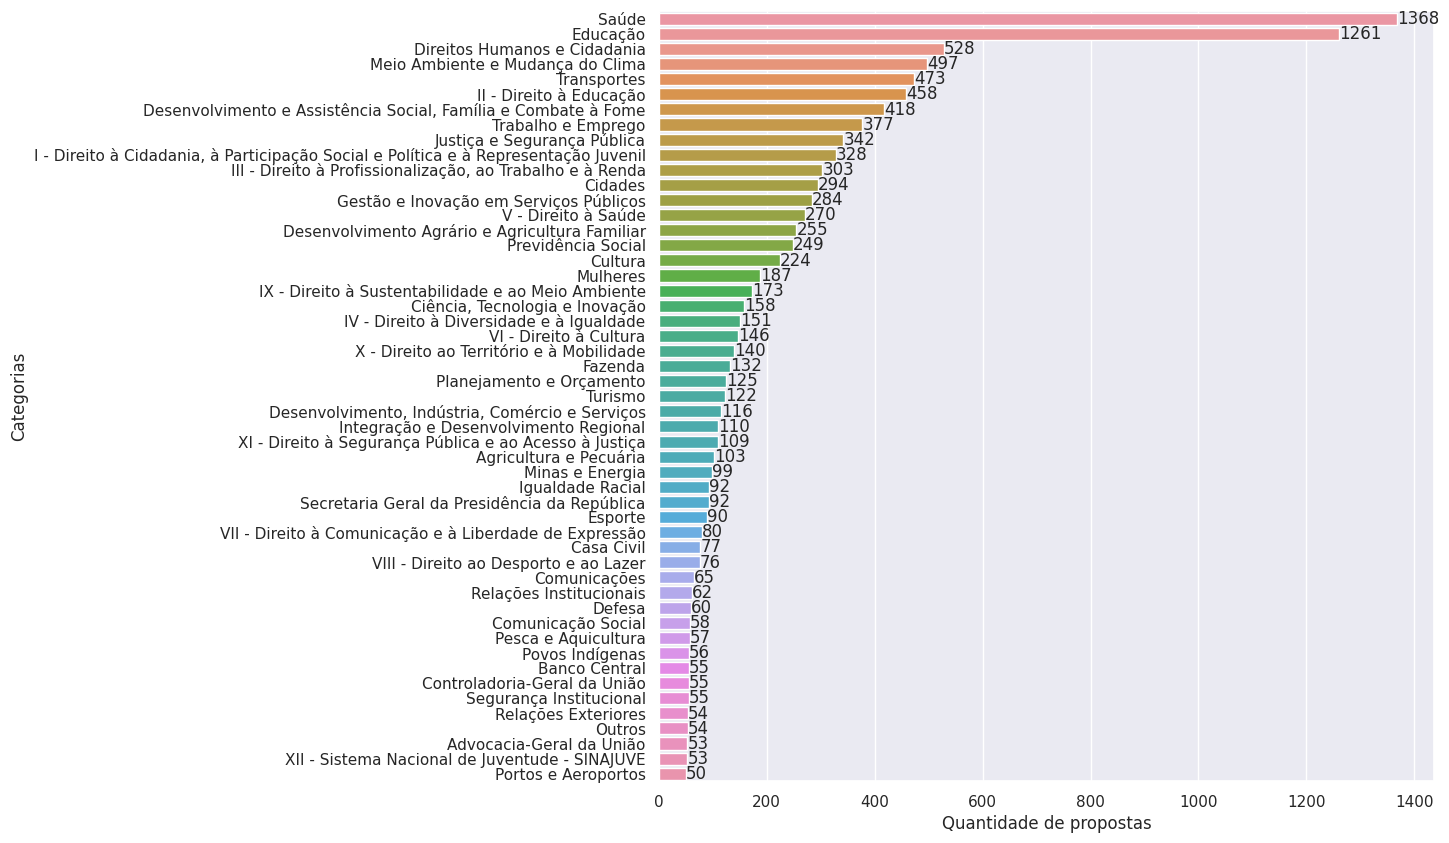

In [8]:
plot_distribution()

Durante o desenvolvimento, também foram explorados modelos few-shot para classificação com poucos dados, porém ainda assim o modelo não performou bem. Modelos de classificação few-shot ainda possuem um caráter recente e não possuem bibliotecas, frameworks e documentações bem consolidadas para integrar um produto mínimo viável. 

<a id='pre-processing'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Pré-processamento Textual</h2>

Durante o pré-processamento, o objetivo é manipular as informações importantes para que o algoritmo de Machine Learning consiga entender e ser treinado. Algoritmos de Machine Learning não entendem dados textuais (não estruturados) e necessitam que eles sejam estruturados de forma que possam ser utilizados para treinamento. Para isso, os dados textuais serão processados, desta vez para gerar uma representação vetorial, conhecido como _Word Vector_ ou _Word Embedding_.

Além disso, nesta etapa, o texto de cada proposta será ajustado para otimização do modelo, retirando palavras do texto que possuam baixo valor semântico e padronização variações conjugais para o processo de aprendizado de máquina. Essa limpeza é necessária para aumentar a precisão dos resultados do modelo treinado. Importante ressaltar que várias alternativas foram exploradas para aumentar precisão do modelo. Abaixo, segue uma versão de como o texto de uma proposta chega assim que é extraído da plataforma:

In [9]:
# Para visualização do conteúdo da coluna "Texto" em uma proposta
print("ANTES DO PRÉ-PROCESSAMENTO")
print(f'{propostas["Texto"].iloc[0]}')

ANTES DO PRÉ-PROCESSAMENTO
Turismo: esse é o Destino. <p><strong>Objetivo:</strong> Posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.<br><br><strong>Órgão Responsável:</strong> Ministério do Turismo<br><br><strong>Página Oficial: </strong>https://www.gov.br/turismo/pt-br/</p>


Um [_Word Vector_](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/) ([aqui](https://dzone.com/articles/introduction-to-word-vectors) também) é nada mais do que uma vetor numérico de pesos ou ocorrências que busca aproximar o significado de uma palavra dado o vocabulário ao qual ele pertence e o contexto no qual ele é utilizado. Existem várias técnicas para isso (_Bag of Words_, _Word2Vec_, _TF-IDF_, _GloVe_, N-grams, ...) e geralmente se utiliza de conceitos comuns em Machine Learning como Redes Neurais e Redução de Dimensionalidade na matriz de coocorrência de palavras, ou então modelos probabilísticos, métodos de base de conhecimento explicável até mesmo uma representação explícita com base no contexto em que a palavra aparece. No MVP, foi utilizado a técnica TF-IDF.

<a id='pre-processing-1'></a><h3 style="font-size:1.5rem;">Definições iniciais</h3>

Nas definições iniciais, é declarado duas variáveis para expressões regulares e uma lista com classes gramaticais a serem excluídas. Depois, é instanciado o pipeline em português da biblioteca spaCy para realização do pré-processamento.

In [10]:
# Expressões regulares para remoção de poluição de dados nos textos 
# REGX_URL = r"https?://[A-Za-z0-9./\-]+" # Regex for URLs
REGX_HTML = r"<[^<]+?>" # Regex for HTML tags
REGX_ENDING = r'Órgão Responsável:.+' # Regex for the part of the text
POS_TAGS = ['AUX', 'ADP', 'ADV', 'CCONJ', 'DET', 'INTJ', 'NUM']

In [11]:
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

# Instanciando o pipeline em português do spaCy
# nlp = spacy.blank('pt') # Pipeline vazio para teste (apenas tokenização)
# nlp = spacy.load('pt_core_news_sm')   # Pipeline pequeno (para eficiência), não possui vector (?)
# nlp = spacy.load('pt_core_news_md')   # Pipeline médio, com vector (500k keys, 20k unique vectors, 300 dimensions)
nlp = spacy.load('pt_core_news_lg')   # Pipeline grande (para precisão), com vector (500k keys, 500k unique vectors, 300 dimensions)

O [spaCy](https://spacy.io/usage/spacy-101) é uma biblioteca gratuita e _open source_ para Processamento de Linguagem Natural avançado em Python. Foi especificamente projetada para uso em produção e para auxiliar na criação de aplicações que processam e "entendem" grandes volumes de texto. Ela pode ser usada para realizar a extração de informações, construir sistemas de compreensão de linguagem natural ou para pré-processar texto para modelos de Machine Learning e Deep Learning.

<a id='pre-processing-2'></a><h3 style="font-size:1.5rem">Pré-processamento</h3>

<a id='pre-processing-2-1'></a><h4 style="font-size:1.3rem">Indexação das categorias</h4>

Primeiro, é feito a indexação de cada uma das categorias. Isto é, atribuir um valor númerico que identifique unicamente cada uma das categorias existentes.

In [12]:
#Criando índices para as categorias
cats = propostas['Categoria'].unique() # Pegando cada categoria única
cats = dict(enumerate(cats, 0)) # Convertendo para dict (com índices enumerados)
cats = {v:k for k,v in cats.items()}  # Trocando chaves e valores

propostas['id_cats'] = propostas['Categoria'].map(cats) # Inserindo coluna de índices das cats
propostas.head()

,Categoria,Texto,id_cats
0,Turismo,"Turismo: esse é o Destino. <p><strong>Objetivo:</strong> Posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.<br><br><strong>Órgão Responsável:</strong> Ministério do Turismo<br><br><strong>Página Oficial: </strong>https://www.gov.br/turismo/pt-br/</p>",0
1,Desenvolvimento Agrário e Agricultura Familiar,"Agricultura Familiar e Agroecologia. <p><strong>Objetivo: </strong>Fortalecer a agricultura familiar em sua diversidade e a agroecologia, promovendo a inclusão socioeconômica, com fomento à produção sustentável e à geração de renda, contribuindo para a promoção da segurança alimentar e nutricional e da vida digna, com redução das desigualdades e mitigação das mudanças climáticas.<br><br><strong>Órgão Responsável: </strong>Ministério do Desenvolvimento Agrário<br><strong><br>Página Oficial:</strong> <a href=""https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1"" rel=""noopener noreferrer"" target=""_blank"">https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1</a></p>",1
2,Agricultura e Pecuária,"Agropecuária Sustentável. <p>Objetivo: Contribuir para o desenvolvimento do setor agropecuário, com sustentabilidade ambiental, econômica e social, por meio do fomento e da intensificação da produção; da geração, compartilhamento e aplicação de conhecimento técnico-científico; e da regulamentação, certificação, auditoria e fiscalização agropecuária.</p><p>Órgão Responsável: Ministério da Agricultura e Pecuária</p><p>Página Oficial: http://www.gov.br/agricultura/pt-br/</p>",2
3,Saúde,"Atenção Primária à Saúde. <p>Fortalecer a Atenção Primária à Saúde, ampliando a cobertura da Estratégia de Saúde da Família e da Saúde Bucal, com vistas à universalização do acesso, à abrangência do cuidado integral, à promoção da saúde, à prevenção de agravos e à redução de desigualdades de raça/etnia, de gênero, regionais e sociais</p><p><strong>Órgão Responsável</strong>: Ministério da Saúde</p><p><strong>Página Oficial</strong>: https://www.gov.br/saude/pt-br/</p><p>Foto: Divulgação/Governo Federal</p>",3
4,Saúde,"Atenção Especializada à Saúde. <p>Ampliar o acesso às ações e serviços da Atenção Especializada à Saúde, conforme as necessidades de saúde da população, reduzindo as desigualdades de raça/etnia, de gênero, regionais e sociais, e promovendo a integralidade do cuidado</p><p><strong>Órgão Responsável</strong>: Ministério da Saúde</p><p><strong>Página Oficial</strong>: <a href=""https://www.gov.br/saude/pt-br/"" rel=""noopener noreferrer"" target=""_blank"">https://www.gov.br/saude/pt-br/</a></p><p>Foto: Divulgação/Ministério da Saúde</p>",3


<a id='pre-processing-2-2'></a><h4 style="font-size:1.3rem">Técnicas de NLP</h4>

Em seguida, como pode-se perceber na prévia de texto, existem informações de tags HTML e informações ao final do texto que fogem do conteúdo das propostas. Além disso, muitas palavras no texto tem pouco valor semântico e não são úteis para a classificação textual. Para limpar essas informações, é definido uma função "cleaning" que aplicará as modificações desejadas em cada linha do DataFrame.

As técnicas de NLP utilizadas no pré-processamento foram:
- Tokenização
- Lematização
- Padronização do texto em minúsculo
- Remoção de _stop words_, acentos e classes gramaticais (tags _part of speech_, ou POS)

In [13]:
# Função para remoção de tags HTML e do texto no final das propostas
def cleaning(text):

  text = re.sub(REGX_HTML, '', text)  # Removendo tags HTML
  text = re.sub(REGX_ENDING, '', text)
  text = text.lower()

  # Tokenização, Lematização, remoção de Stop Words e pontuações
  tokens = [t.lemma_ for t in nlp(text) if t not in STOP_WORDS and not t.is_punct and t.pos_ not in POS_TAGS]

  return ' '.join(tokens)

#  Ajustando textos da coluna Corpo
propostas['Texto Processado'] = propostas['Texto'].apply(cleaning)
propostas.head()

,Categoria,Texto,id_cats,Texto Processado
0,Turismo,"Turismo: esse é o Destino. <p><strong>Objetivo:</strong> Posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.<br><br><strong>Órgão Responsável:</strong> Ministério do Turismo<br><br><strong>Página Oficial: </strong>https://www.gov.br/turismo/pt-br/</p>",0,turismo esse destino objetivo posicionar turismo vetor desenvolvimento sustentável aumentar competitividade destino produto turístico brasileiro democratizar acesso atividade turístico cidadão brasileiro
1,Desenvolvimento Agrário e Agricultura Familiar,"Agricultura Familiar e Agroecologia. <p><strong>Objetivo: </strong>Fortalecer a agricultura familiar em sua diversidade e a agroecologia, promovendo a inclusão socioeconômica, com fomento à produção sustentável e à geração de renda, contribuindo para a promoção da segurança alimentar e nutricional e da vida digna, com redução das desigualdades e mitigação das mudanças climáticas.<br><br><strong>Órgão Responsável: </strong>Ministério do Desenvolvimento Agrário<br><strong><br>Página Oficial:</strong> <a href=""https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1"" rel=""noopener noreferrer"" target=""_blank"">https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1</a></p>",1,agricultura familiar agroecologia objetivo fortalecer agricultura familiar diversidade agroecologia promover inclusão socioeconômico fomento produção sustentável geração renda contribuir promoção segurança alimentar nutricional vida digna redução desigualdade mitigação mudança climático
2,Agricultura e Pecuária,"Agropecuária Sustentável. <p>Objetivo: Contribuir para o desenvolvimento do setor agropecuário, com sustentabilidade ambiental, econômica e social, por meio do fomento e da intensificação da produção; da geração, compartilhamento e aplicação de conhecimento técnico-científico; e da regulamentação, certificação, auditoria e fiscalização agropecuária.</p><p>Órgão Responsável: Ministério da Agricultura e Pecuária</p><p>Página Oficial: http://www.gov.br/agricultura/pt-br/</p>",2,agropecuária sustentável objetivo contribuir desenvolvimento setor agropecuário sustentabilidade ambiental econômico social meio fomento intensificação produção geração compartilhamento aplicação conhecimento técnico-científico regulamentação certificação auditoria fiscalização agropecuário
3,Saúde,"Atenção Primária à Saúde. <p>Fortalecer a Atenção Primária à Saúde, ampliando a cobertura da Estratégia de Saúde da Família e da Saúde Bucal, com vistas à universalização do acesso, à abrangência do cuidado integral, à promoção da saúde, à prevenção de agravos e à redução de desigualdades de raça/etnia, de gênero, regionais e sociais</p><p><strong>Órgão Responsável</strong>: Ministério da Saúde</p><p><strong>Página Oficial</strong>: https://www.gov.br/saude/pt-br/</p><p>Foto: Divulgação/Governo Federal</p>",3,atenção primário saúde fortalecer atenção primário saúde ampliar cobertura estratégia saúde família saúde bucal vista universalização acesso abrangência cuidado integral promoção saúde prevenção agravo redução desigualdade raça etnia gênero regional social
4,Saúde,"Atenção Especializada à Saúde. <p>Ampliar o acesso às ações e serviços da Atenção Especializada à Saúde, conforme as necessidades de saúde da população, reduzindo as desigualdades de raça/etnia, de gênero, regionais e sociais, e promovendo a integralidade do cuidado</p><p><strong>Órgão Responsável</strong>: Ministério da Saúde</p><p><strong>Página Oficial</strong>: <a href=""https://www.gov.br/saude/pt-br/"" rel=""noopener noreferrer"" target=""_blank"">https://www.gov.br/saude/pt-br/</a></p><p>Foto: Divulgação/Ministério da Saúde</p>",3,atenção especializar saúde ampliar acesso ação serviço atenção especializar saúde conforme necessidade saúde população reduzir desigualdade

In [14]:
# Agora com o texto filtrado
print("DEPOIS DO PRÉ-PROCESSAMENTO")
print(f'{propostas["Texto Processado"].iloc[0]}')

DEPOIS DO PRÉ-PROCESSAMENTO
turismo esse destino objetivo posicionar turismo vetor desenvolvimento sustentável aumentar competitividade destino produto turístico brasileiro democratizar acesso atividade turístico cidadão brasileiro


<a id='pre-processing-3'></a><h3 style="font-size:1.5rem">Vetorização Textual</h3>

![TF-IDF](https://miro.medium.com/max/3136/1*ruCawEw0--m2SeHmAQooJQ.jpeg)

Enfim, criamos uma representação vetorial do texto a partir da técnica TF-IDF disponível pela biblioteca do Scikit-Learn e guardamos os vetores em uma nova coluna chamada "Vector".

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer 

# Aqui, estamos criando uma lista 'docs' a partir da coluna 'Texto' do DataFrame 'propostas'.
docs = list(propostas['Texto Processado'])

# A próxima linha configura o vetorizador TF-IDF com uso de IDF (Inverse Document Frequency) e um limite máximo de recursos em 50,000.
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), use_idf=True, max_features=50000)

# Aqui, estamos transformando os documentos da lista 'docs' em vetores TF-IDF.
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)

# Finalmente, estamos convertendo os vetores TF-IDF em uma matriz NumPy e armazenando-a na variável 'docs'.
docs = tfidf_vectorizer_vectors.toarray()

print(docs.shape)
propostas['Vector'] = docs.tolist()

(11094, 19176)


<a id='text-clustering'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Agrupamento em Tópicos</h2>

**Modelagem de tópicos** (_Topic Modelling_) é uma técnica para extrair tópicos ocultos presentes em grandes volumes de textos através da clusterização/agrupamento dos documentos. É uma abordagem de _machine learning_ não supervisionada, ou seja, não necessita que os dados estejam previamente rotulados.

No caso dos dados de propostas do Brasil Participativo, é uma técnica muito útil para auxiliar na organização das propostas em temáticas recorrentes e uma forma de priorizar e direcionar os temas mais importantes presentes nas propostas para que as pautas sejam identificadas e atendidas.

O conceito de tópico pode ser definido num primeiro momento como um padrão repetitivo de termos coocorrentes em um corpus (conjunto de documentos). Um bom modelo de tópico, por exemplo, poderia apresentar os termos "saúde", "médico", "paciente" e "hospital" para um tópico "Saúde", ou os termos "futebol", "competição", "atleta", "jogador", "partida" e "vôlei" para um tópico "Esporte".

Existem alguns algoritmos e modelos para a realização do Topic Modelling, o mais utilizado entre eles é o **Latent Dirichlet Allocation (LDA)**, criado por Blei et al. em 2003. O LDA é um modelo probabilístico generativo, similar ao Naive Bayes, que assume que cada tópico é uma mistura de um conjunto subjacente de palavras (termos) e que cada documento é uma mistura de um conjunto de probabilidades de tópicos. O LDA então pressupõe duas premissas:

- Documentos que possuem palavras similares geralmente possuem o mesmo tópico.
- Documentos que possuem grupos de palavras ocorrendo frequentemente em conjunto geralmente possuem o mesmo tópico.

Matematicamente, as premissas podem ser definidas como:

- Documentos são distribuições de probabilidade sobre os tópicos latentes
- Tópicos são distribuições de probabilidade sobre palavras

A implementação utilizada do LDA é a encontrada no biblioteca [Gensim](https://radimrehurek.com/gensim/index.html). Além disso, será utilizado a biblioteca [Spacy](https://radimrehurek.com/gensim/index.html) para pré-processamento do texto.

Antes de iniciar, segue abaixo os módulos e pacotes a serem importados. Garanta que tudo esteja instalado adequadamente.

In [16]:
# For visualization
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
sns.set()

In [17]:
# Gensim module with modules and capabilities
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook

<a id='text-clustering-1'></a><h3 style="font-size:1.5rem">Pré-processamento</h3>

Para o agrupamento em tópicos, partiremos dos textos (documentos) não processados ainda. As técnicas utilizadas aqui são bem similares às técnicas utilizadas anteriormente, diferindo nas classes gramaticais a serem retiradas:
- Transformação em lowercase
- Extração de textos (HTML, ...)
- Extração de tags _Part-Of-Speech_
- Remoção de _stop words_ e números
- Tokenização e lematização

In [18]:
def cleaning(text):
  text = re.sub(REGX_HTML, '', text)  # Removendo tags HTML
  text = re.sub(REGX_ENDING, '', text)  # Removendo texto desnecessário no final
  text = text.lower()

  return text

# Cleaning text from column "Texto"
propostas['Texto_Tópicos'] = propostas['Texto'].apply(cleaning)
propostas.head()

,Categoria,Texto,id_cats,Texto Processado,Vector,Texto_Tópicos
0,Turismo,"Turismo: esse é o Destino. <p><strong>Objetivo:</strong> Posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.<br><br><strong>Órgão Responsável:</strong> Ministério do Turismo<br><br><strong>Página Oficial: </strong>https://www.gov.br/turismo/pt-br/</p>",0,turismo esse destino objetivo posicionar turismo vetor desenvolvimento sustentável aumentar competitividade destino produto turístico brasileiro democratizar acesso atividade turístico cidadão brasileiro,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]","turismo: esse é o destino. objetivo: posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros."
1,Desenvolvimento Agrário e Agricultura Familiar,"Agricultura Familiar e Agroecologia. <p><strong>Objetivo: </strong>Fortalecer a agricultura familiar em sua diversidade e a agroecologia, promovendo a inclusão socioeconômica, com fomento à produção sustentável e à geração de renda, contribuindo para a promoção da segurança alimentar e nutricional e da vida digna, com redução das desigualdades e mitigação das mudanças climáticas.<br><br><strong>Órgão Responsável: </strong>Ministério do Desenvolvimento Agrário<br><strong><br>Página Oficial:</strong> <a href=""https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1"" rel=""noopener noreferrer"" target=""_blank"">https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1</a></p>",1,agricultura familiar agroecologia objetivo fortalecer agricultura familiar diversidade agroecologia promover inclusão socioeconômico fomento produção sustentável geração renda contribuir promoção segurança alimentar nutricional vida digna redução desigualdade mitigação mudança climático,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]","agricultura familiar e agroecologia. objetivo: fortalecer a agricultura familiar em sua diversidade e a agroecologia, promovendo a inclusão socioeconômica, com fomento à produção sustentável e à geração de renda, contribuindo para a promoção da segurança alimentar e nutricional e da vida digna, com redução das desigualdades e mitigação das mudanças climáticas."
2,Agricultura e Pecuária,"Agropecuária Sustentável. <p>Objetivo: Contribuir para o desenvolvimento do setor agropecuário, com sustentabilidade ambiental, econômica e social, por meio do fomento e da intensificação da produção; da geração, compartilhamento e aplicação de conhecimento técnico-científico; e da regulamentação, certificação, auditoria e fiscalização agropecuária.</p><p>Órgão Responsável: Ministério da Agricultura e Pecuária</p><p>Página Oficial: http://www.gov.br/agricultura/pt-br/</p>",2,agropecuária sustentável objetivo contribuir desenvolvimento setor agropecuário sustentabilidade ambiental econô

In [19]:
REMOVAL_TAGS = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
COMMON_WORDS = ['público', 'programa']
COMMON_WORDS = [nlp(w)[0] for w in COMMON_WORDS]

# Spacy model:
# nlp = pt_core_news_md.load()

tokens = []
# Getting lemmas + removing stop words, numeric tokens and unwanted POS tags 
for texto in nlp.pipe(propostas['Texto']):
   proj_tok = [token.lemma_ for token in texto
               if token.pos_ not in REMOVAL_TAGS and
               token not in COMMON_WORDS and
               not token.is_stop and
               token.is_alpha]
   tokens.append(proj_tok)


print('\n'.join([str(t) for t in tokens[0:5]]))

['turismo', 'Destino', 'Posicionar', 'turismo', 'vetor', 'desenvolvimento', 'sustentável', 'aumentar', 'competitividade', 'destino', 'produto', 'turístico', 'brasileiro', 'democratizar', 'acesso', 'atividade', 'turístico', 'cidadão', 'Órgão', 'Ministério', 'Turismo', 'Página', 'Oficial', 'turismo']
['Agricultura', 'Familiar', 'Agroecologia', 'objetivo', 'Fortalecer', 'agricultura', 'familiar', 'diversidade', 'agroecologia', 'promover', 'inclusão', 'socioeconômico', 'fomento', 'produção', 'sustentável', 'geração', 'renda', 'contribuir', 'promoção', 'segurança', 'alimentar', 'nutricional', 'vida', 'digna', 'redução', 'desigualdade', 'mitigação', 'mudança', 'Órgão', 'Responsável', 'Ministério', 'Desenvolvimento', 'agrário', 'Página', 'agricultura', 'assunto', 'mda', 'noreferrer', 'agricultura', 'assunto', 'mda']
['Agropecuária', 'Sustentável', 'p', 'objetivo', 'contribuir', 'desenvolvimento', 'setor', 'agropecuário', 'sustentabilidade', 'ambiental', 'econômico', 'social', 'fomento', 'inte

<a id='text-clustering-2'></a><h3 style="font-size:1.5rem">Vetorização com BoW</h3>

O modelo LDA do Gensim utiliza a vetorização com a técnica BoW. As duas principais entradas do modelo LDA são o dicionário e o corpus.

- Dicionário: Uma lista com cada palavra do corpus indexada a um único ID
- Corpus: Com um ID atribuído a cada palavra, o corpus simplesmente contém cada ID e sua frequência

In [20]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(tokens)
print(dictionary.token2id)
print(f'\nQuantidade de palavras únicas: {len(dictionary)}')

{'Destino': 0, 'Ministério': 1, 'Oficial': 2, 'Posicionar': 3, 'Página': 4, 'Turismo': 5, 'acesso': 6, 'atividade': 7, 'aumentar': 8, 'brasileiro': 9, 'cidadão': 10, 'competitividade': 11, 'democratizar': 12, 'desenvolvimento': 13, 'destino': 14, 'produto': 15, 'sustentável': 16, 'turismo': 17, 'turístico': 18, 'vetor': 19, 'Órgão': 20, 'Agricultura': 21, 'Agroecologia': 22, 'Desenvolvimento': 23, 'Familiar': 24, 'Fortalecer': 25, 'Responsável': 26, 'agricultura': 27, 'agroecologia': 28, 'agrário': 29, 'alimentar': 30, 'assunto': 31, 'contribuir': 32, 'desigualdade': 33, 'digna': 34, 'diversidade': 35, 'familiar': 36, 'fomento': 37, 'geração': 38, 'inclusão': 39, 'mda': 40, 'mitigação': 41, 'mudança': 42, 'noreferrer': 43, 'nutricional': 44, 'objetivo': 45, 'produção': 46, 'promover': 47, 'promoção': 48, 'redução': 49, 'renda': 50, 'segurança': 51, 'socioeconômico': 52, 'vida': 53, 'Agropecuária': 54, 'Sustentável': 55, 'agropecuário': 56, 'ambiental': 57, 'aplicação': 58, 'auditoria':

In [21]:
# Filtering out low-frequency and high-frequency tokens, also limitting the vocabulary to a max of 5000 words
# (May be useful for taking out outliers)
dictionary.filter_extremes(no_below=6, no_above=0.4, keep_n=5000)
print(dictionary.token2id)
print(f'\nQuantidade de palavras únicas, após filtragem: {len(dictionary)}')

{'Ministério': 0, 'Oficial': 1, 'Página': 2, 'Turismo': 3, 'acesso': 4, 'atividade': 5, 'aumentar': 6, 'brasileiro': 7, 'cidadão': 8, 'competitividade': 9, 'democratizar': 10, 'desenvolvimento': 11, 'destino': 12, 'produto': 13, 'sustentável': 14, 'turismo': 15, 'turístico': 16, 'vetor': 17, 'Órgão': 18, 'Agricultura': 19, 'Agroecologia': 20, 'Desenvolvimento': 21, 'Familiar': 22, 'Fortalecer': 23, 'Responsável': 24, 'agricultura': 25, 'agroecologia': 26, 'agrário': 27, 'alimentar': 28, 'assunto': 29, 'contribuir': 30, 'desigualdade': 31, 'digna': 32, 'diversidade': 33, 'familiar': 34, 'fomento': 35, 'geração': 36, 'inclusão': 37, 'mitigação': 38, 'mudança': 39, 'noreferrer': 40, 'nutricional': 41, 'objetivo': 42, 'produção': 43, 'promover': 44, 'promoção': 45, 'redução': 46, 'renda': 47, 'segurança': 48, 'socioeconômico': 49, 'vida': 50, 'Agropecuária': 51, 'Sustentável': 52, 'agropecuário': 53, 'ambiental': 54, 'aplicação': 55, 'auditoria': 56, 'certificação': 57, 'compartilhamento':

In [22]:
# Construct corpus
# doc2bow simply counts the number of occurrences of each distinct word, converts the word to
# its integer word id and returns the result as a sparse vector
corpus = [dictionary.doc2bow(doc) for doc in tokens]

<a id='text-clustering-3'></a><h3 style="font-size:1.5rem">Construção e seleção do melhor modelo</h3>

Aqui, é selecionado o modelo LdaMulticore pois com é possível aproveitar o processamento paralelo em CPU/GPU e acelerar o treinamento. Para o modelo, é passado o corpus processado com BoW, o dicionário, a quantidade de iterações sobre o corpus (50 interações), a quantidade de tópicos (10), os trabalhadores/processos (8) para executar o ajuste do modelo e o número de vezes/passes (10) no corpus que serão realizados no treinamento.

In [23]:
# Testing
# lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 8, passes=10)

Buscando a quantidade ideal de tópicos, definiu-se um intervalo de 5 a 40 para realizar os testes. O intervalo considerado reflete a quantidade de categorias de ministérios nos quais as propostas também são classificadas. Apesar disso, o objetivo da modelagem de tópicos não é encontrar as categorias de ministérios, e sim encontrar uma outra forma de classificação das propostas.

100%|██████████| 35/35 [06:11<00:00, 10.60s/it]


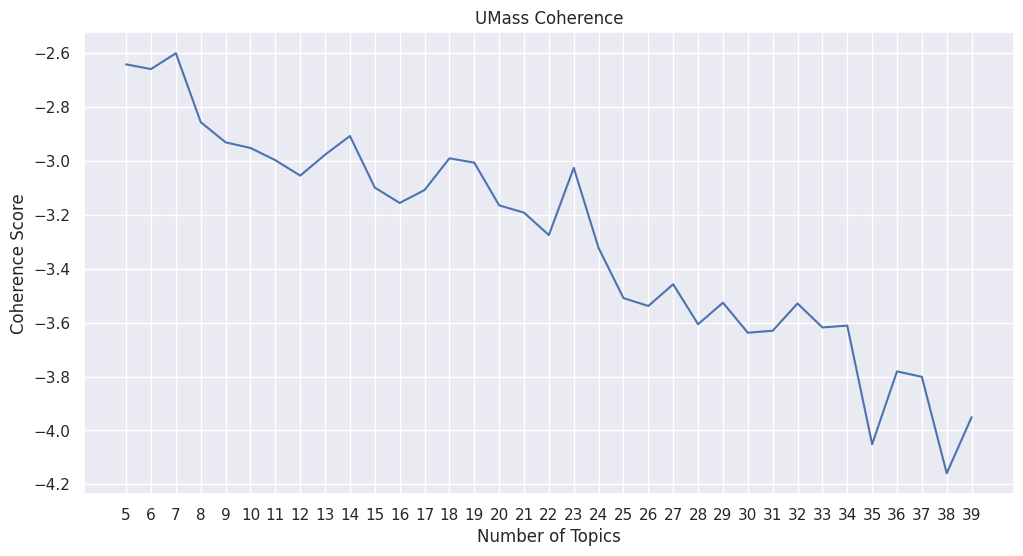

In [24]:
# Calculating the coherence score using C_umass
# for finding the optimal number of topics
topics_c_umass = []
score_c_umass = []

for i in tqdm(range(5,40,1)):
  lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    chunksize=5000,     # controls how many documents are processed at a time
    iterations=10,      # controls how often we repeat a particular loop over each document
    num_topics=i,
    workers = 8,
    passes=10,          # controls how many documents are processed at a time (epochs)
    random_state=100)
  cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
  topics_c_umass.append(i)
  score_c_umass.append(cm.get_coherence())

_=plt.figure(figsize=(12,6))
_=plt.plot(topics_c_umass, score_c_umass)
_=plt.title("UMass Coherence")
_=plt.xticks(np.arange(min(topics_c_umass), max(topics_c_umass)+1, 1.0))
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

100%|██████████| 35/35 [09:14<00:00, 15.83s/it]


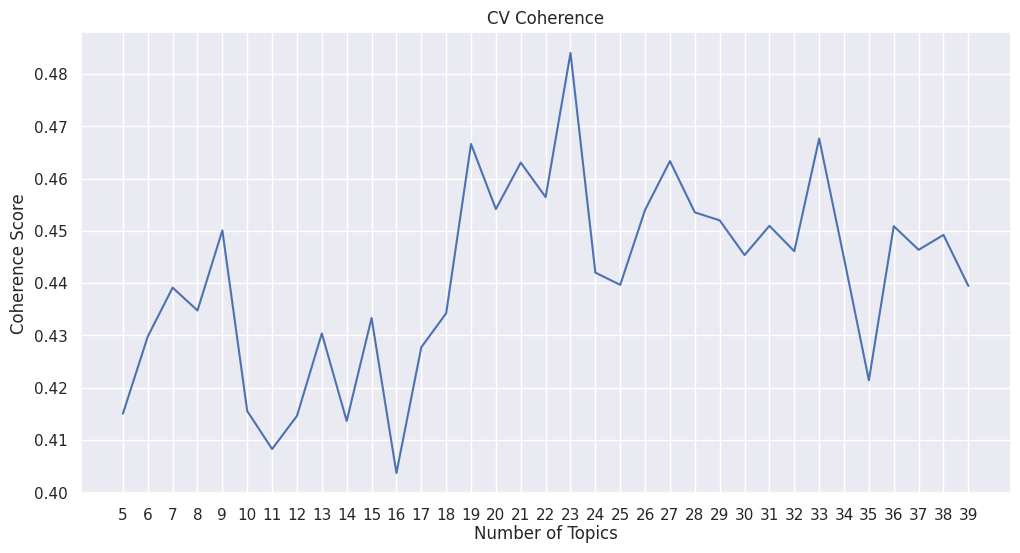

In [25]:
# Calculating the coherence score using C_v
# for finding the optimal number of topics
topics_c_v = []
score_c_v = []

for i in tqdm(range(5,40,1)):
  lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    chunksize=5000,     # controls how many documents are processed at a time
    iterations=10,      # controls how often we repeat a particular loop over each document
    num_topics=i,
    workers = 8,
    passes=10,          # controls how many documents are processed at a time (epochs)
    random_state=100)
  
  cm = CoherenceModel(model=lda_model, texts = tokens, corpus=corpus, dictionary=dictionary, coherence='c_v')
  topics_c_v.append(i)
  score_c_v.append(cm.get_coherence())

_=plt.figure(figsize=(12,6))
_=plt.plot(topics_c_v, score_c_v)
_=plt.title("CV Coherence")
_=plt.xticks(np.arange(min(topics_c_v), max(topics_c_v)+1, 1.0))
_=plt.xlabel('Number of Topics', labelpad=2)
_=plt.ylabel('Coherence Score')
plt.show()

In [26]:
# Model with optimal number of topics (MODIFICAR A QUANTIDADE DE TÓPICOS)
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=23, workers = 8, passes=100, random_state=100)

<a id='text-clustering-4'></a><h3 style="font-size:1.5rem">Visualização dos tópicos</h3>

In [27]:
lda_model.print_topics(-1)

[(0,
  '0.064*"trabalho" + 0.034*"emprego" + 0.029*"pessoa" + 0.029*"mercado" + 0.029*"empresa" + 0.015*"oportunidade" + 0.014*"Segurança" + 0.012*"segurança" + 0.011*"Brasil" + 0.011*"público"'),
 (1,
  '0.020*"produção" + 0.019*"rural" + 0.018*"desenvolvimento" + 0.014*"cultural" + 0.013*"comunidade" + 0.011*"indígena" + 0.011*"familiar" + 0.010*"agricultura" + 0.009*"programa" + 0.008*"cultura"'),
 (2,
  '0.040*"segurança" + 0.025*"esporte" + 0.013*"esportivo" + 0.012*"crime" + 0.012*"uso" + 0.011*"policial" + 0.010*"Brasil" + 0.010*"polícia" + 0.008*"droga" + 0.008*"força"'),
 (3,
  '0.031*"público" + 0.020*"política" + 0.018*"cultura" + 0.017*"espaço" + 0.014*"criação" + 0.014*"direito" + 0.014*"social" + 0.012*"garantir" + 0.011*"cultural" + 0.010*"ser"'),
 (4,
  '0.037*"Nacional" + 0.021*"público" + 0.016*"recurso" + 0.016*"Saúde" + 0.013*"criação" + 0.013*"política" + 0.011*"Política" + 0.011*"estadual" + 0.010*"Lei" + 0.010*"SUS"'),
 (5,
  '0.067*"salário" + 0.057*"piso" + 0.0

In [28]:
print(propostas['Texto'][0])
print(lda_model[corpus][0])

Turismo: esse é o Destino. <p><strong>Objetivo:</strong> Posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.<br><br><strong>Órgão Responsável:</strong> Ministério do Turismo<br><br><strong>Página Oficial: </strong>https://www.gov.br/turismo/pt-br/</p>
[(1, 0.84077775), (6, 0.055887926), (12, 0.06551755)]


In [29]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

<a id='text-clustering-5'></a><h3 style="font-size:1.5rem">Adicionando tópicos ao DataFrame</h3>

In [30]:
# Adding topics into the DataFrame
propostas['Topicos'] = [sorted(lda_model[corpus][texto])[0][0] for texto in range(len(propostas['Texto']))]
propostas.head()

,Categoria,Texto,id_cats,Texto Processado,Vector,Texto_Tópicos,Topicos
0,Turismo,"Turismo: esse é o Destino. <p><strong>Objetivo:</strong> Posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.<br><br><strong>Órgão Responsável:</strong> Ministério do Turismo<br><br><strong>Página Oficial: </strong>https://www.gov.br/turismo/pt-br/</p>",0,turismo esse destino objetivo posicionar turismo vetor desenvolvimento sustentável aumentar competitividade destino produto turístico brasileiro democratizar acesso atividade turístico cidadão brasileiro,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]","turismo: esse é o destino. objetivo: posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.",1
1,Desenvolvimento Agrário e Agricultura Familiar,"Agricultura Familiar e Agroecologia. <p><strong>Objetivo: </strong>Fortalecer a agricultura familiar em sua diversidade e a agroecologia, promovendo a inclusão socioeconômica, com fomento à produção sustentável e à geração de renda, contribuindo para a promoção da segurança alimentar e nutricional e da vida digna, com redução das desigualdades e mitigação das mudanças climáticas.<br><br><strong>Órgão Responsável: </strong>Ministério do Desenvolvimento Agrário<br><strong><br>Página Oficial:</strong> <a href=""https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1"" rel=""noopener noreferrer"" target=""_blank"">https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1</a></p>",1,agricultura familiar agroecologia objetivo fortalecer agricultura familiar diversidade agroecologia promover inclusão socioeconômico fomento produção sustentável geração renda contribuir promoção segurança alimentar nutricional vida digna redução desigualdade mitigação mudança climático,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]","agricultura familiar e agroecologia. objetivo: fortalecer a agricultura familiar em sua diversidade e a agroecologia, promovendo a inclusão socioeconômica, com fomento à produção sustentável e à geração de renda, contribuindo para a promoção da segurança alimentar e nutricional e da vida digna, com redução das desigualdades e mitigação das mudanças climáticas.",1
2,Agricultura e Pecuária,"Agropecuária Sustentável. <p>Objetivo: Contribuir para o desenvolvimento do setor agropecuário, com sustentabilidade ambiental, econômica e social, por meio do fomento e da intensificação da produção; da geração, compartilhamento e aplicação de conhecimento técnico-científico; e da regulamentação, certificação, auditoria e fiscalização agropecuária.</p><p>Órgão Responsável: Ministério da Agricultura e Pecuária</p><p>Página Oficial: http://www.gov.br/agricultura/pt-br/</p>",2,agropecuária sustentável objetivo contribuir desenvolvimento setor agropecuário sustentabilidade amb

In [31]:
# Counting the frequency of each topic
propostas.Topicos.value_counts()

Topicos
0     1964
1     1832
3     1238
2     1075
4      985
5      786
6      480
8      402
7      376
10     312
9      285
13     284
11     270
14     166
12     135
19     126
15     113
16      87
17      78
18      40
20      26
21      24
22      10
Name: count, dtype: int64

<a id='dataset'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Dataset de Propostas do Brasil Participativo</h2>


Ao final do pré-processamento e do agrupamento das propostas em tópicos, temos um dataset apropriado para treinamento de um modelo para classificação textual. Esses dados podem ser salvos e utilizados para treinamento futuramente com outros modelos, além do definido aqui. Abaixo, será salvo o dataset para controle e versionamento dos dados.

In [34]:
# Reorganizando colunas
propostas = propostas[['id_cats', 'Categoria', 'Texto', 'Texto Processado', 'Vector']]

# Salvando dataset para classificação textual das propostas do Brasil Participativo
propostas.to_csv('model/propostas_brasilparticipativo_v1_1_0.csv', index=False)

# Remove o csv antigo 
# os.remove('production/data_extraction/brasilparticipativo.presidencia.gov.br-open-data-proposals.csv')

In [35]:
# Compressão do CSV (arquivo CSV é muito grande)
with ZipFile('model/propostas_brasilparticipativo_v1_1_0.zip', 'w') as zip_object:
   # Adding files that need to be zipped
   zip_object.write('model/propostas_brasilparticipativo_v1_1_0.csv')
   
# Checando se o arquivo Zip foi criado
if os.path.exists('model/propostas_brasilparticipativo_v1_1_0.zip'):
   print("Arquivo ZIP criado!")
else:
   print("Arquivo ZIP não criado!")

# Remove o dataset csv 
# os.remove('model/propostas_brasilparticipativo_v1_0_0.csv')

Arquivo ZIP criado!


<a id='training-model'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Classificação de Propostas</h2>

O modelo ML utilizado neste MVP para classificação de propostas foi determinado através de um benchmark de vários algoritmos. Os algoritmos foram avaliados com base na sua precisão e tempo de treinamento, duas métricas para examinar qual modelo se adequa às necessidades e exigências do caso de uso. Dos algoritmos estudados, a maioria foi implementado com a biblioteca do Scikit-Learn, com exceção de dois. Os algoritmos são os seguintes:
- Random Forest
- Nearest Neighbors
- Support Vector Machine
- Multinomial Naive Bayes
- Rede Neural Profunda do Tensorflow
- TextCat do spaCy

Desta forma, optou-se por utilizar Support Vector Machine ([SVM](https://scikit-learn.org/stable/modules/svm.html#support-vector-machines)) por exibir melhor precisão e menor tempo de treinamento. O benchmark foi realizado em um [dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset) diferente (com mais dados para treinamento, mesmo assim, com o formato de dados semelhantes com os dados das propostas) e posteriormente no dataset de propostas do Brasil Participativo.

<a id='training-model-1'></a><h3 style="font-size:1.5rem">Importação de bibliotecas</h3>

A biblioteca do Scikit-Learn possui vários módulos úteis para realização do treinamento de um algoritmo de Machine Learning, como funções para avaliar a precisão, formas de otimização do algoritmo. pré-processamento e outros além do próprio algoritmo utilizado.

In [36]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm, model_selection
import warnings
warnings.filterwarnings('ignore')

<a id='training-model-2'></a><h3 style="font-size:1.5rem">Configurações do modelo</h3>

Primeiramente, os dados das propostas (colunas "Vector" e "id_cats") são parametrizados pelo Scikit-Learn. O dataset é embaralhado e dividido em dados para treinamento e teste, sendo 70% utilizado para treinamento e 30% para teste.

In [37]:
# Atribui a variável X ao conjunto de dados 'docs'
X = docs

# Atribui a variável y à coluna 'id_cats' do DataFrame 'propostas'
y = propostas['id_cats']

# Imprime as dimensões (formato) de X e y, ou seja, o número de linhas e colunas
print(X.shape, y.shape)

(11094, 19176) (11094,)


In [38]:
# Definindo a semente para garantir reprodutibilidade
SEED = 123      # Nunca utilizar em produção

# Dividindo o conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, propostas.Categoria, test_size=0.3, random_state=SEED, stratify=propostas.Categoria)

Agora, o modelo é instanciado, realizado o treinamento com a função `fit`. Em seguida, os dados de teste são utilizados para imprimir um relatório com a performance em cada categoria e sua perfomance geral. O relatório também pode ser encontrado em `model/training_results`.

In [39]:
import json

clf = svm.LinearSVC(class_weight='balanced')  # Cria um classificador Linear Support Vector Machine (SVM) com pesos de classe balanceados.

# Registra o tempo que leva para treinar o modelo SVC com os dados de treinamento.
%time clf.fit(X_train, y_train)

# Faz previsões com o modelo treinado nos dados de treinamento e teste.
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Salvando relatório de treinamento em um arquivo JSON
json_obj = json.dumps(classification_report(y_test, y_pred_test, output_dict=True), indent=4)
save_file = open('model/training_results.json', 'w').write(json_obj)

# Calcula e imprime a pontuação de acurácia do modelo nos dados de treinamento.
print("\nTraining Accuracy score:", accuracy_score(y_train, y_pred_train)*100)

# Calcula e imprime a pontuação de acurácia do modelo nos dados de teste.
print("Testing Accuracy score:", accuracy_score(y_test, y_pred_test)*100)

# Imprime o report do nosso modelo de classificação
print(classification_report(y_test, y_pred_test))

CPU times: user 981 ms, sys: 6.92 ms, total: 988 ms
Wall time: 987 ms

Training Accuracy score: 97.269800386349
Testing Accuracy score: 50.64583959146891
                                                                                     precision    recall  f1-score   support

                                                           Advocacia-Geral da União       0.75      0.75      0.75        16
                                                             Agricultura e Pecuária       0.35      0.23      0.27        31
                                                                      Banco Central       0.67      0.75      0.71        16
                                                                         Casa Civil       0.50      0.52      0.51        23
                                                                            Cidades       0.35      0.38      0.36        88
                                                     Ciência, Tecnologia e Inovação       0.37 

Algumas observações a se destacar é que o modelo MVP ainda não atinge uma performance alta o suficiente para utilização em produção. A precisão geral (_accuracy score_) do algoritmo é de 50%. Em certas categorias atinge uma métrica satisfatória acima dos 85%, porém em outras não consegue inferir corretamente se alguma proposta pertence a tal categoria.

Isso se deve primeiramente pelo pouco volume de dados presentes no dataset do Brasil Participativo. As categorias com menos propostas não possuem uma quantia suficiente para treinar e avaliar a performance do algoritmo.

Várias tentativas de otimizações foram avaliadas para serem realizadas no algoritmo, porém o problema da falta de dados não pode ser contornado. O modelo necessita de mais dados, principalmente nas categorias com menos propostas, para ter uma performance boa na classificação geral.

<a id='how-to-use'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Utilização</h2>

Com o modelo treinado, é possível então carregá-lo em um arquivo serializado para persistência e utilização futura, acoplado a um outro sistema por exemplo.

Existem várias formas de serializar um objeto Python (o modelo MVP treinado, no caso). As formas mais comuns de serem utilizadas é através das bibliotecas Pickle (nativa do Python) ou Joblib (que utiliza a anterior). Detalhes para a serialização com elas podem ser vistas [aqui](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/). Apesar de serem as mais comuns, o Scikit-Learn aponta algumas [limitações de segurança e mantenibilidade](https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations). Uma alternativa segura para serializar e carregar em Python seria a biblioteca [Skops](https://skops.readthedocs.io/en/stable/), mais recomendada.

O Skops fornece um formato mais seguro, evitando o uso de Pickle e carregando apenas arquivos que possuem tipos e referências a funções nas quais são confiáveis por padrão ou pelo desenvolvedor Além disso, o seu uso é muito semelhante ao uso do Pickle.

Além desta forma de reuso e utilização do modelo, para integração do modelo treinado com uma aplicação Ruby on Rails utilizou-se o formato [ONNX](https://onnx.ai/get-started.html) que é um formato comum de utilização em diferentes linguagens incluindo o Ruby. Isso se dá visto que o sistema do Brasil Participativo é implementado com essa linguagem.

<a id='how-to-use-1'></a><h3 style="font-size:1.5rem">Serialização</h3>

Para a serialização, é utilizado a biblioteca [skl2onnx](https://pypi.org/project/skl2onnx/) com a função `to_onnx` que converte o modelo do Scikit-Learn para o formato ONNX, passando o modelo treinado e os dados de treinamento escalonados.

In [40]:
from skl2onnx import to_onnx

onx = to_onnx(clf, X_train[:1].astype(np.float32))

Em seguida, o modelo é salvo em um arquivo `.onnx`, conforme o comando abaixo:

In [ ]:
with open("./model/proposal_classifier_v1_1_0.onnx", "wb") as f:
    f.write(onx.SerializeToString())

<a id='how-to-use-2'></a><h3 style="font-size:1.5rem">Carregamento</h3>

Para recarregar o modelo em algum sistema Python, utiliza-se a biblioteca [onnxruntime](https://pypi.org/project/onnxruntime/) com os seguintes comandos:

In [ ]:
import onnxruntime as rt

sess = rt.InferenceSession("./model/proposal_classifier_v1_1_0.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name


pred_onx = sess.run([label_name], {input_name: [X_test[0]]})[0]

print('PROPOSTA: ', propostas['Texto Processado'].iloc[0])
print('CATEGORIA: ', propostas['Categoria'].iloc[0])
print(f'INFERÊNCIA DA CATEGORIA: {pred_onx[0]}')

<a id='history'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Histórico de versão do Pipeline</h2>

| Data       | Autor                                        | Modificações                          | Versão |
| ---------- | -------------------------------------------- | ------------------------------------- | ------ |
| 15/08/2023 | [Alexandre Oliveira](https://github.com/LexTOliver) | Primeira versão | 1.0    |
| 26/09/2023 | [Chaydson Ferreira](https://github.com/chaydson) | Exportando modelo para ONNX | 1.1    |
| 06/11/2023 | [João Anacleto](https://github.com/jpanacleto2) | Otimizações no modelo | 1.2    |
| 06/11/2023 | [Alexandre Oliveira](https://github.com/LexTOliver) | Ajustes nas otimizações e versionamento do dataset | 1.3    |
| 12/12/2023 | [Alexandre Oliveira](https://github.com/LexTOliver) | Agrupamento de propostas por tópico | 1.4    |